# Translating Plate at 60°

In [1]:
using PotentialFlow

## Set up

At the beginning of every time-step, we first determine the bound vortex sheet strength required to satisfy the no-flow-through condition, then velocity of all vortex elements:

In [2]:
function compute_ẋ!(ẋ, x, t)
    plate, ambient_sys = x
    motion, ambient_vel = ẋ
    
    Plates.enforce_no_flow_through!(plate, motion, ambient_sys, t)
    
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x, t)
end

compute_ẋ! (generic function with 1 method)

Once we have advected all the vortex elements, we release new segments of the vortex sheet from the edges of the plate.
In this case, the strength of the segments are set to enforce the Kutta condition on both edges.

In [3]:
function shed_new_vorticity!(sheet₊, sheet₋, plate, motion, t, lesp = 0.0, tesp = 0.0)
    z₊ = (sheet₊.blobs[end].z + 2plate.zs[end])/3
    z₋ = (sheet₋.blobs[end].z + 2plate.zs[1])/3
    
    segment₊ = Vortex.Blob.([sheet₊.blobs[end].z, z₊], [0.5, 0.5], δ)
    segment₋ = Vortex.Blob.([sheet₋.blobs[end].z, z₋], [0.5, 0.5], δ)
    Plates.enforce_no_flow_through!(plate, motion, (sheet₊, sheet₋), t)
    
    Γ₊, Γ₋, _, _ = Plates.vorticity_flux!(plate, segment₊, segment₋, t, lesp, tesp);
    Vortex.Sheets.append_segment!(sheet₊, z₊, Γ₊)
    Vortex.Sheets.append_segment!(sheet₋, z₋, Γ₋)
end

shed_new_vorticity! (generic function with 3 methods)

### Discretize the plate and sheets

We are simulating a flat plate with zero thickness impulsively translating horizontally at a fixed velocity and angle of attack

In [4]:
L = 2.0   # chord length
N = 128   # number of plate control points (distributed along a extrema Chebyshev grid)

ċ = 0.5L  # translation velocity
α = π/3   # angle of attack

Δt = 1e-2; # time step

plate = Plate(N, L, zero(Complex128), α)
motion = Plates.RigidBodyMotion(ċ, 0.0);

We place the initial segments of the vortex sheets perpendicularly off each edge of the plate.
The sheets themselves are represented as discrete vortex blobs, all with the same blob radius `δ`.
Both segments initially have unit circulation.

In [5]:
Δz₀ = im*Δt*exp(im*α)
z₋, z₊ = plate.zs[[1,N]]

δ = 0.2

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, 1.0], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, 1.0], δ)

Vortex Sheet: L ≈ 0.01, Γ = 1.0, δ = 0.2

We then adjust the circulation of the vortex sheet segments to satisfy the Kutta condition.
In this library, the vorticity flux from the edges of the plate is determined through the edge suction parameters.
The Kutta condition simply corresponds to the suction parameters being zero at both edges.

In [6]:
lesp = tesp = 0.0
Plates.enforce_no_flow_through!(plate, motion, (), 0)

Γ₊, Γ₋, _, _ = Plates.vorticity_flux(plate, sheet₊, sheet₋, 0, lesp, tesp);

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, Γ₊], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, Γ₋], δ)

Vortex Sheet: L ≈ 0.01, Γ = -0.489, δ = 0.2

We organize the flow elements into the plate and ambient elements.

In [7]:
ambient_sys = (sheet₊, sheet₋)
sys = (plate, ambient_sys)
sys₊ = deepcopy(sys) # Used for storage during time-marching
ẋs = (motion, allocate_velocity(ambient_sys));

# Storage for pressure and forces
pressures = Vector{Float64}[];
Γs₋ = circulation(ambient_sys) .+ Plates.bound_circulation(plate);
forces = Complex128[];

## Time-Marching

We use forward Euler to evolve the system and apply filtering on both the leading and trailing edge vortex sheets to surpress small-scale instabilities.

In [8]:
tf = 9
T = 0:Δt:tf

for t in T
    plate, ambient_ω = sys
    motion, ambient_u = ẋs
    
    TimeMarching.forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    # The force is computed based on the rate of change of impulse, which
    # requires information about:
    # - the plate's motion, 
    # - the strength, position, and velocity of the ambient vortex elements
    # - the vorticity flux from the plate edges
    push!(forces, Plates.force(plate, motion, ambient_ω, ambient_u,
            (ambient_ω[1].blobs[end], ambient_ω[2].blobs[end]), Δt))
    
    # To calculate the pressure, we need the rate of change of the bound
    # circulation distribution.  That also includes the bound vortex sheets
    # generated by the newly shed vortex elements.  In order to account for
    # that, we tell the `surface_pressure_inst` function where the new
    # vortex elements are going to be released from so that it can compute
    # their circulation.
    push!(pressures, 
        let z₊ = (sys[2][1].blobs[end].z + 2sys[1].zs[end])/3
            z₋ = (sys[2][1].blobs[end].z + 2sys[1].zs[1])/3
    
        Plates.surface_pressure_inst(plate, motion, ambient_ω,
            (z₊, z₋), t, Δt, lesp, tesp)
    end)
    
    sys₊, sys = sys, sys₊

    # Redistribute the points along the free vortex sheet to be at least 3UΔt
    # apart from each other.  At the same time, we filter out any length scales
    # along the sheet shorter than 6UΔt
    for s in 1:2
        Sheets.arclength(sys[2][s]) ≥ 3Δt && Sheets.filter!(sys[2][s], 3Δt, 6Δt)
    end
    
    shed_new_vorticity!(sys[2][1], sys[2][2], sys[1], ẋs[1], t + Δt, lesp, tesp)
end

## Plotting

Most flow elements in the library has [plot recipes](https://github.com/JuliaPlots/RecipesBase.jl) defined for them.
So once [`Plots.jl`](https://github.com/JuliaPlots/Plots.jl) is installed along with the appropriate backend, we can directly call `plot` on the potential flow elements.

In [9]:
using Plots
clibrary(:colorbrewer)
default(grid = false)


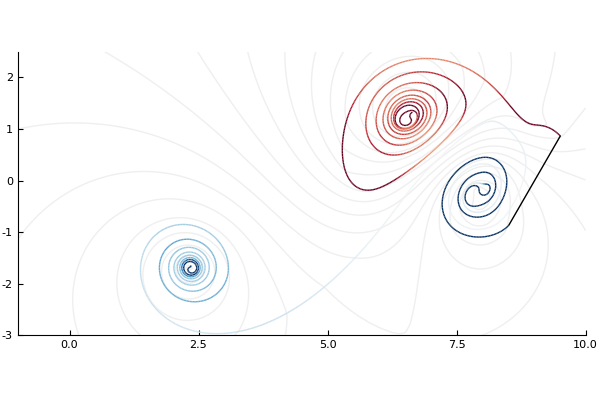

In [10]:
streamlines(-1:0.1:10, -3:0.1:2.5, sys, clim = (-3, 3), levels = collect(-3:0.3:3), color = cgrad(["#efefef", "#efefef"]))
plot!(sys, color = :RdBu_r, clim = (-0.5, 0.5), legend = :none, cbar = :none, ratio = 1, colorbar_title = "\$\\gamma\$")

### Forces

We computed the force on the plate in two different ways:

- we computed the distribution of pressure differences across the plate along its control points.
Since the plate control points are along an extrema Chebyshev grid, we can use the Clenshaw Curtis quadrature to integrate the pressure difference and find the normal force on the plate
- we summed up the rate of change of impulse all the vortex elements in the system


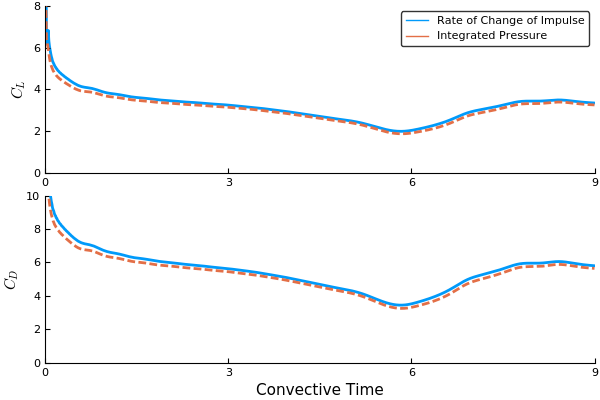

In [11]:
let w = 0.5L*Plates.Chebyshev.clenshaw_curtis_weights(N),
    labels = ["Rate of Change of Impulse" "Integrated Pressure"]
    Fₚ = map(pressures) do p
            -im*exp(im*plate.α)*(w[2:end-1] ⋅ p[2:end-1])
        end
    
    plt = plot(layout = (2,1), size = (600, 400))
    plot!(plt[1], T, 2*[imag.(forces) imag.(Fₚ)], 
          linewidth = 2, linestyle = [:solid :dash],
          ylim = (0, 8), ylabel = "\$C_L\$", label = labels)
    
    plot!(plt[2], T, -2*[real.(forces) real.(Fₚ)], 
          linewidth = 2, linestyle = [:solid :dash],
          ylim = (0, 10), ylabel = "\$C_D\$", xlabel = "Convective Time", legend = :none)
    plt
end